In [ ]:
%%capture
# !pip install -U tf2onnx
# !pip install onnxruntime
!pip install torchcam
# !pip install onnx2pytorch
# !pip install tf2onnx
# !pip install onnxruntime

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip '/content/drive/MyDrive/archive (4).zip'

In [ ]:
imgs=os.listdir("/content/ODIR-5K/ODIR-5K/Training Images")

In [ ]:
df=pd.read_excel("/content/ODIR-5K/ODIR-5K/data.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         3500 non-null   int64 
 1   Patient Age                3500 non-null   int64 
 2   Patient Sex                3500 non-null   object
 3   Left-Fundus                3500 non-null   object
 4   Right-Fundus               3500 non-null   object
 5   Left-Diagnostic Keywords   3500 non-null   object
 6   Right-Diagnostic Keywords  3500 non-null   object
 7   N                          3500 non-null   int64 
 8   D                          3500 non-null   int64 
 9   G                          3500 non-null   int64 
 10  C                          3500 non-null   int64 
 11  A                          3500 non-null   int64 
 12  H                          3500 non-null   int64 
 13  M                          3500 non-null   int64 
 14  O       

In [ ]:
findings = df.iloc[:, 7:15]
totals = findings.sum()
totals

N    1140
D    1128
G     215
C     212
A     164
H     103
M     174
O     979
dtype: int64

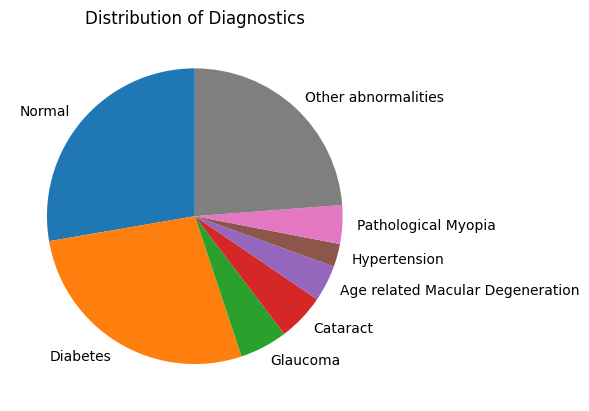

In [ ]:
extended_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']
plt.pie(totals, labels=extended_labels, startangle=90)

plt.title("Distribution of Diagnostics")

plt.show()

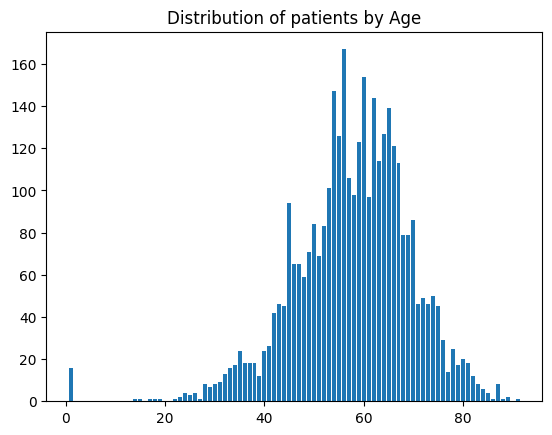

In [ ]:
ages = df['Patient Age'].value_counts()
plt.bar(ages.index, ages)
plt.title("Distribution of patients by Age")
plt.show()

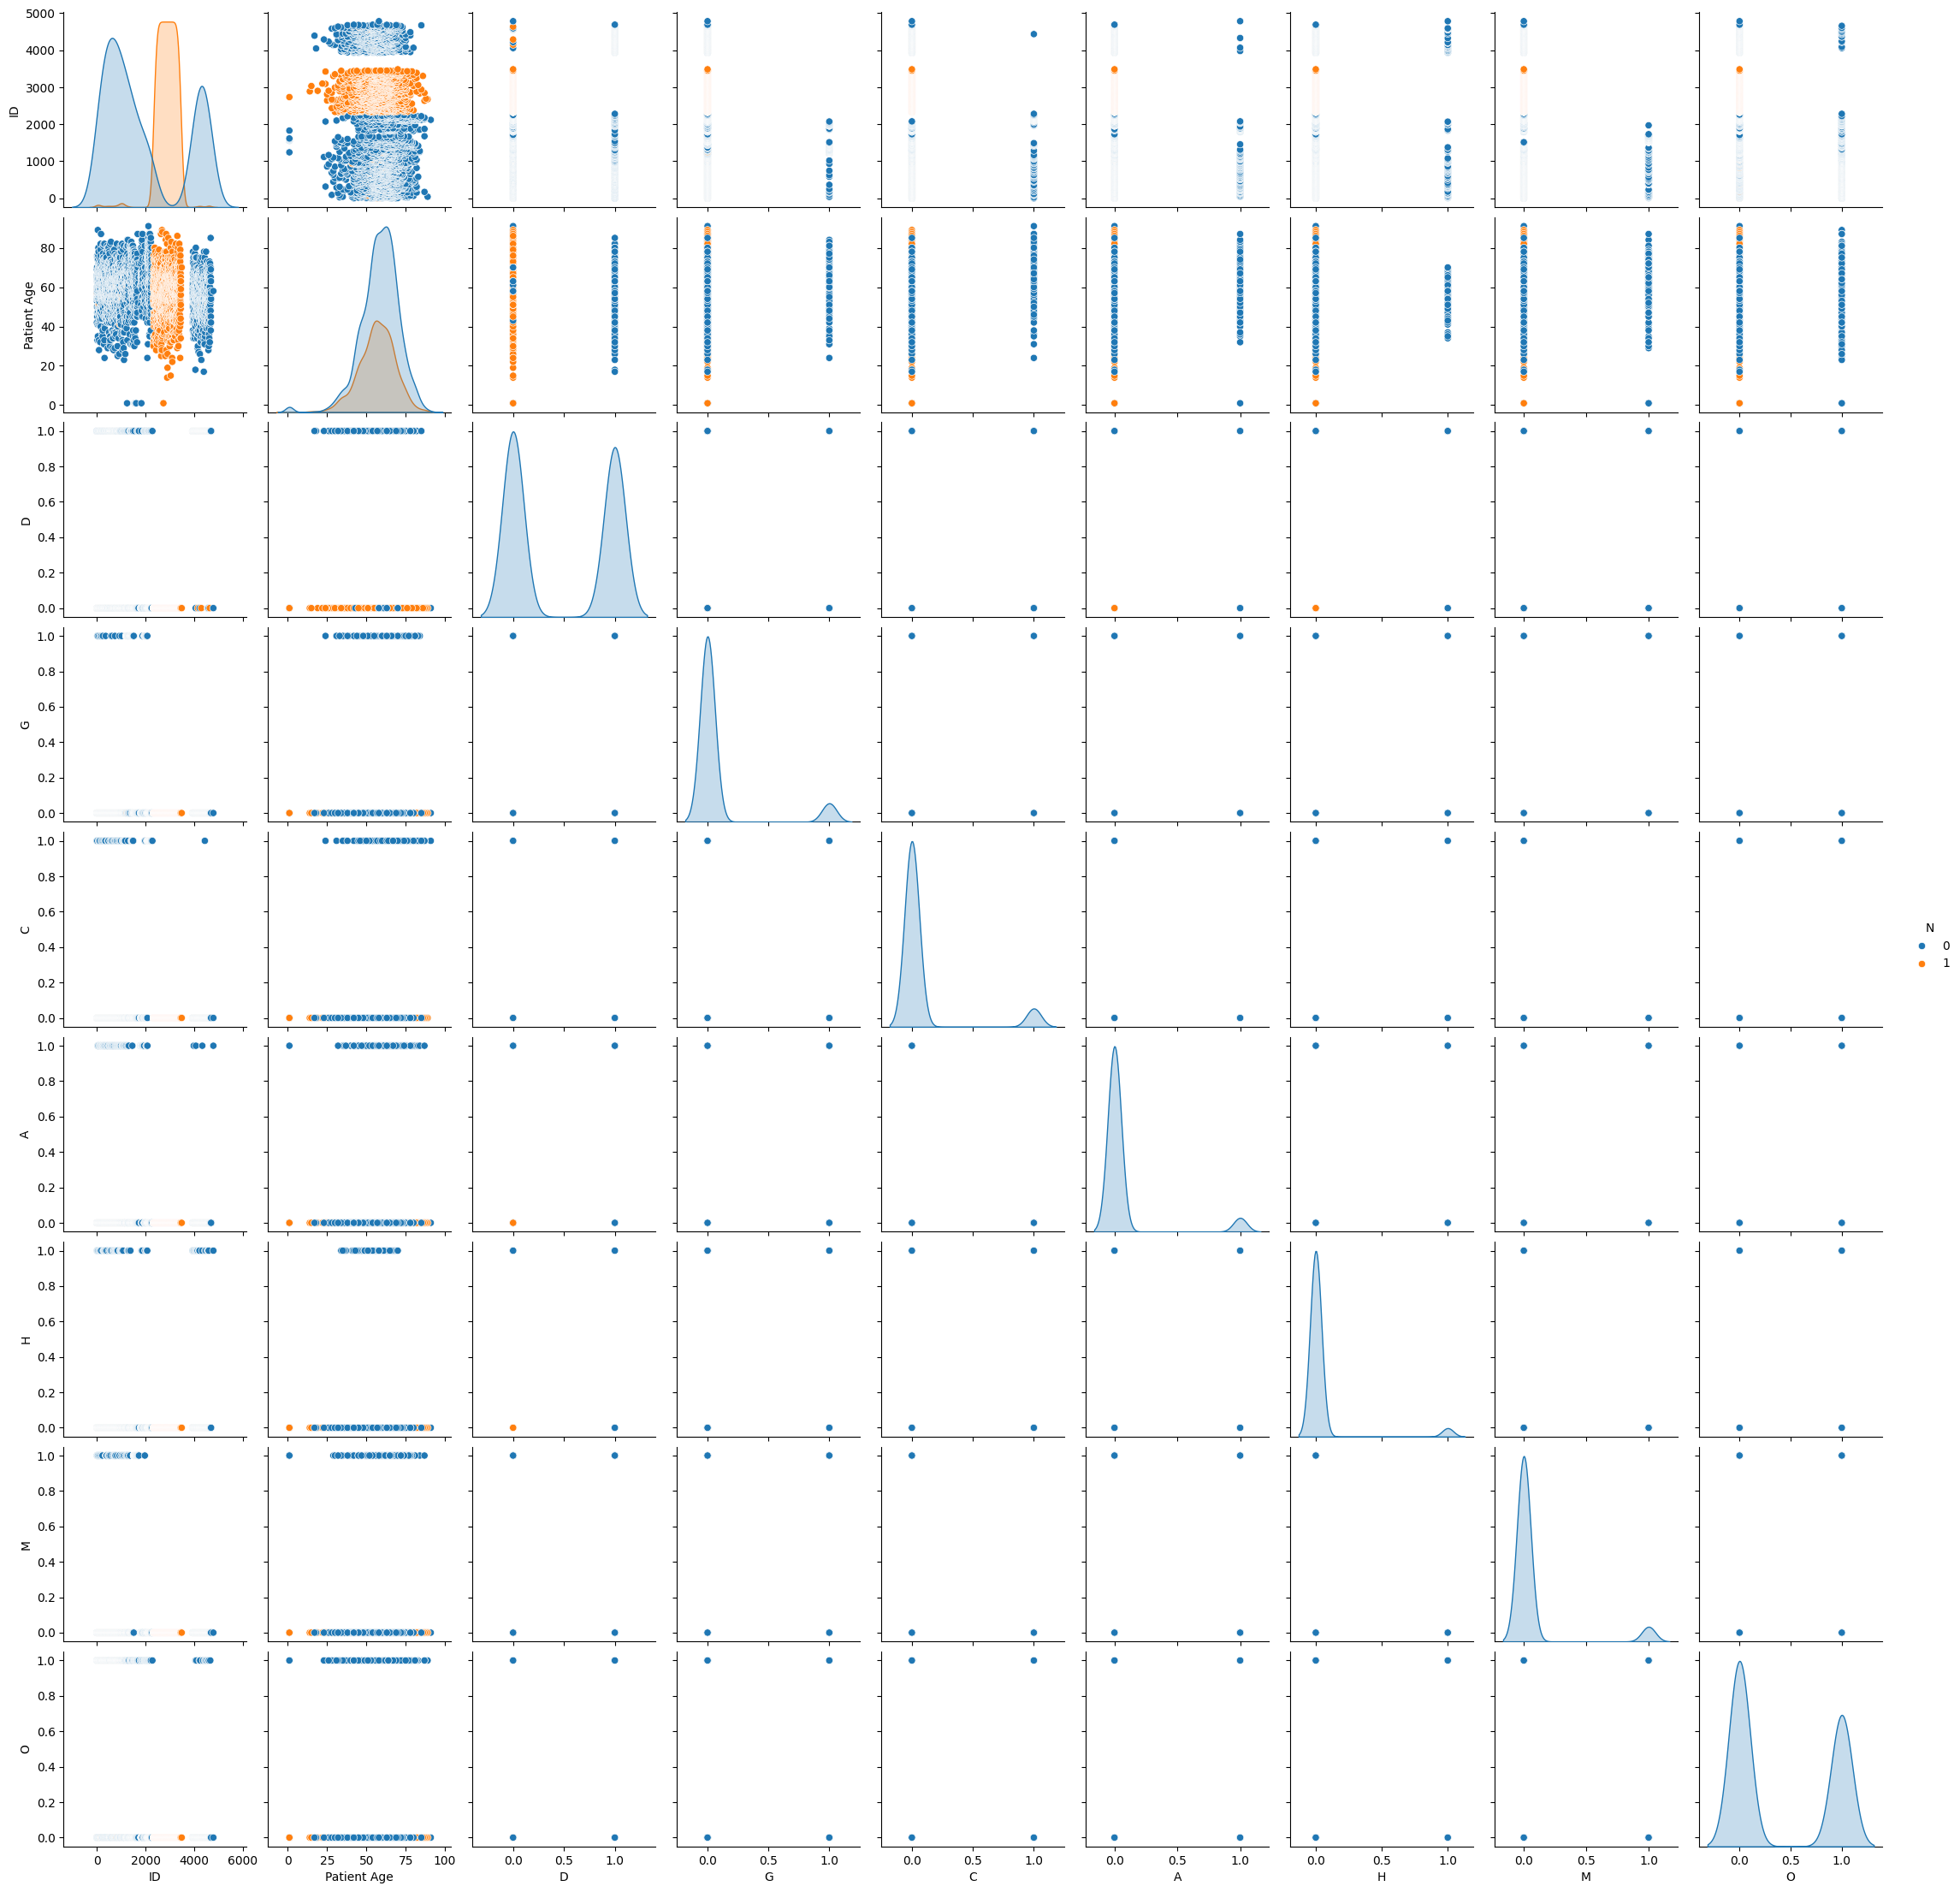

In [ ]:
sns.pairplot(data=df,hue='N')

In [ ]:
from pathlib import Path
import shutil

In [ ]:
!rm -rf /content/data/

In [ ]:
# Source path for training images
source = "/content/ODIR-5K/ODIR-5K/Training Images/"
for j in ['C','N']:
  # Destination path
  p = Path(f'/content/data/train/{j}/')
  p.mkdir(parents = True, exist_ok = True)
  destination = f"/content/data/train/{j}/"

  # Copy the content of
  # source to destination
  l=-10
  if j == 'N':
    l=-10
  for i in list(df[df[j]==1]['Left-Fundus']):
    shutil.copyfile("/content/ODIR-5K/ODIR-5K/Training Images/"+i, destination+i)
  for i in list(df[df[j]==1]['Right-Fundus']):
    shutil.copyfile("/content/ODIR-5K/ODIR-5K/Training Images/"+i, destination+i)

In [ ]:
# Source path for training images
source = "/content/ODIR-5K/ODIR-5K/Training Images/"
for j in ['C','N']:
  # Destination path
  p = Path(f'/content/data/test/{j}/')
  p.mkdir(parents = True, exist_ok = True)
  destination = f"/content/data/test/{j}/"

  # Copy the content of
  # source to destination
  l=-10
  if j == 'N':
    l=-10
  for i in list(df[df[j]==1]['Left-Fundus'])[l:-1]:
    shutil.copyfile(source + i, destination+i)
  for i in list(df[df[j]==1]['Right-Fundus'])[l:-1]:
    shutil.copyfile(source + i, destination+i)

In [ ]:
train_dir = '/content/data/train/'
test_dir = '/content/data/test/'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 2704 files belonging to 2 classes.
Using 2164 files for training.
Found 2704 files belonging to 2 classes.
Using 540 files for validation.
Found 36 files belonging to 2 classes.


In [ ]:
pretrained = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# import torch.nn as nn
# import torchvision

In [ ]:

# class MiniVGGNetModel(nn.Module):
#   def __init__(self, input_shape):
#     super(MiniVGGNetModel, self).__init__()

#     self.rescale = nn.Sequential(
#         nn.Upsample(size=input_shape, mode='bilinear'),
#         # nn.LayerNorm(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     )
#     self.pretrained = torchvision.models.vgg16(pretrained=True).features
#     self.flatten = nn.Flatten()
#     self.fc1 = nn.Linear(25088, 256)
#     self.fc2 = nn.Linear(256, 256)
#     self.out1 = nn.Linear(256, 1)
#     self.act1 = nn.Sigmoid()

#   def forward(self, x):
#     x = self.rescale(x)
#     x = self.pretrained(x)
#     x = self.flatten(x)
#     x = self.fc1(x)
#     x = self.fc2(x)
#     x = self.out1(x)
#     x = self.act1(x)
#     return x

In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0

In [ ]:
cat_list = os.listdir(train_dir)
cat_list.sort()
cat_list = cat_list
lenghts = [len(os.listdir(train_dir + cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['C', 'N']
[424, 2280]
[2.5258661880630178, 1.0908712114635715]


In [ ]:
# import torch.optim as optim

In [ ]:
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
# num_epochs = 10

# # Define the training function
# def train(model, optimizer, criterion, train_loader):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target.unsqueeze(1))
#         loss.backward()
#         optimizer.step()

# # Define the validation function
# def validate(model, criterion, val_loader):
#     model.eval()
#     with torch.no_grad():
#         total_loss = 0.0
#         total_correct = 0.0
#         for data, target in val_loader:
#             output = model(data)
#             loss = criterion(output, target.unsqueeze(1))
#             total_loss += loss.item() * data.size(0)
#             _, predicted = torch.max(output.data, 1)
#             total_correct += (predicted == target).sum().item()
#         avg_loss = total_loss / len(val_loader.dataset)
#         avg_accuracy = total_correct / len(val_loader.dataset)
#         return avg_loss, avg_accuracy

# # Train the model
# for epoch in range(num_epochs):
#     train(model1, optimizer, criterion, training_generator)
#     loss, accuracy = validate(model, criterion, training_generator)
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
# freeze vgg16
# pretrained.trainable = False

model.compile(loss='binary_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
patience = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
history = model.fit(
    training_generator,
    steps_per_epoch=2,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
2/2 [==============================] - 49s 5s/step - loss: 9.8034 - accuracy: 0.5312 - val_loss: 1.3542 - val_accuracy: 0.8281
Epoch 2/100
2/2 [==============================] - 6s 6s/step - loss: 1.2520 - accuracy: 0.9062 - val_loss: 4.8131 - val_accuracy: 0.7969
Epoch 3/100
2/2 [==============================] - 6s 5s/step - loss: 1.6665 - accuracy: 0.8906 - val_loss: 14.7260 - val_accuracy: 0.7812
Epoch 4/100
2/2 [==============================] - 6s 6s/step - loss: 11.4712 - accuracy: 0.7969 - val_loss: 1.5216 - val_accuracy: 0.8125
Epoch 5/100
2/2 [==============================] - 7s 7s/step - loss: 1.3225 - accuracy: 0.8125 - val_loss: 0.8690 - val_accuracy: 0.8906
Epoch 6/100
2/2 [==============================] - 6s 6s/step - loss: 1.2412 - accuracy: 0.8594 - val_loss: 1.7812 - val_accuracy: 0.8125
Epoch 7/100
2/2 [==============================] - 6s 6s/step - loss: 1.2492 - accuracy: 0.8750 - val_loss: 0.8737 - val_accuracy: 0.8906
Epoch 8/100
2/2 [==============

In [ ]:
model.save('/content/vgg16_binary_cataract_normal')

In [ ]:
# ! python -m tf2onnx.convert --saved-model /content/vgg16_binary_cataract_normal --output vgg16_binary_cataract_normal.onnx

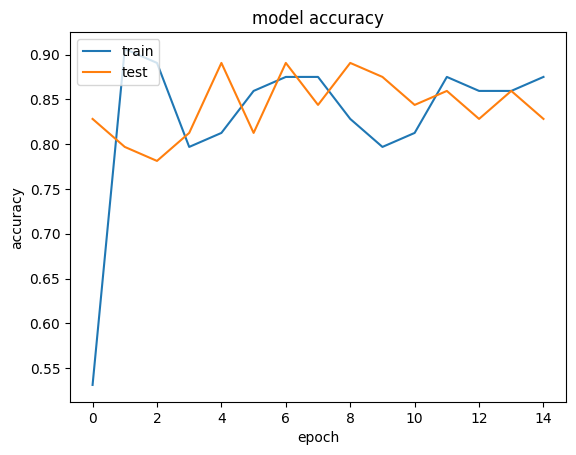

In [ ]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

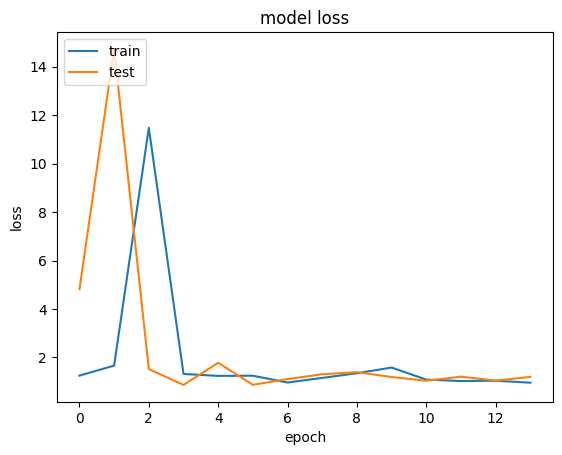

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_generator)

2/2 [==============================] - 4s 3s/step


In [ ]:

y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [ ]:

test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

Text(50.722222222222214, 0.5, 'Truth')

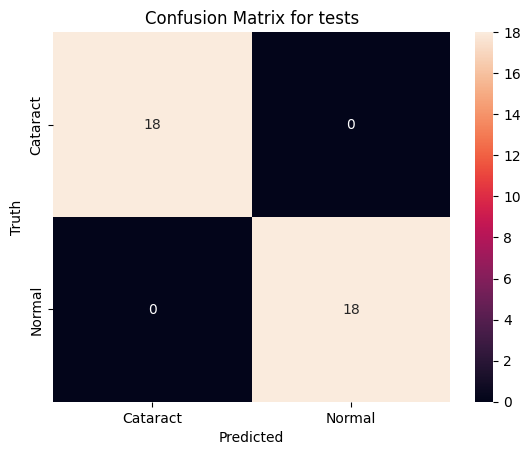

In [ ]:
cf_matrix = confusion_matrix(y_real, y_real)
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix for tests')
ax.xaxis.set_ticklabels(['Cataract','Normal'])
ax.yaxis.set_ticklabels(['Cataract','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# import onnx
# from onnx2pytorch import ConvertModel

# onnx_model = onnx.load('/content/vgg16_binary_cataract_normal.onnx')
# pytorch_model = ConvertModel(onnx_model)

In [ ]:
# print(pytorch_model)

In [ ]:
# import tensorflow as tf
# import tf2onnx
# import onnx
# import torch
# import onnxruntime


# # Convert the TensorFlow model to ONNX
# tf2onnx.convert.from_keras(model, output_path='tf_model.onnx')

# # Load the ONNX model
# onnx_model = onnx.load('tf_model.onnx')
# pytorch_model = onnxruntime.InferenceSession('tf_model.onnx')
# # pytorch_script_model = torch.jit.script(pytorch_model)
# # pytorch_model = onnxruntime.InferenceSession('tf_model.onnx')

# # Convert the ONNX model to PyTorch
# # torch.onnx.export(pytorch_model, torch.randn(1, 3, 264, 264), 'pytorch_model.onnx', opset_version=12)

# # Load the PyTorch model
# # pytorch_model = onnxruntime.InferenceSession('pytorch_model.onnx')

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-74-f51733e4e3c1>:11: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[0,1],axs[0,2])


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


<Figure size 1200x600 with 0 Axes>

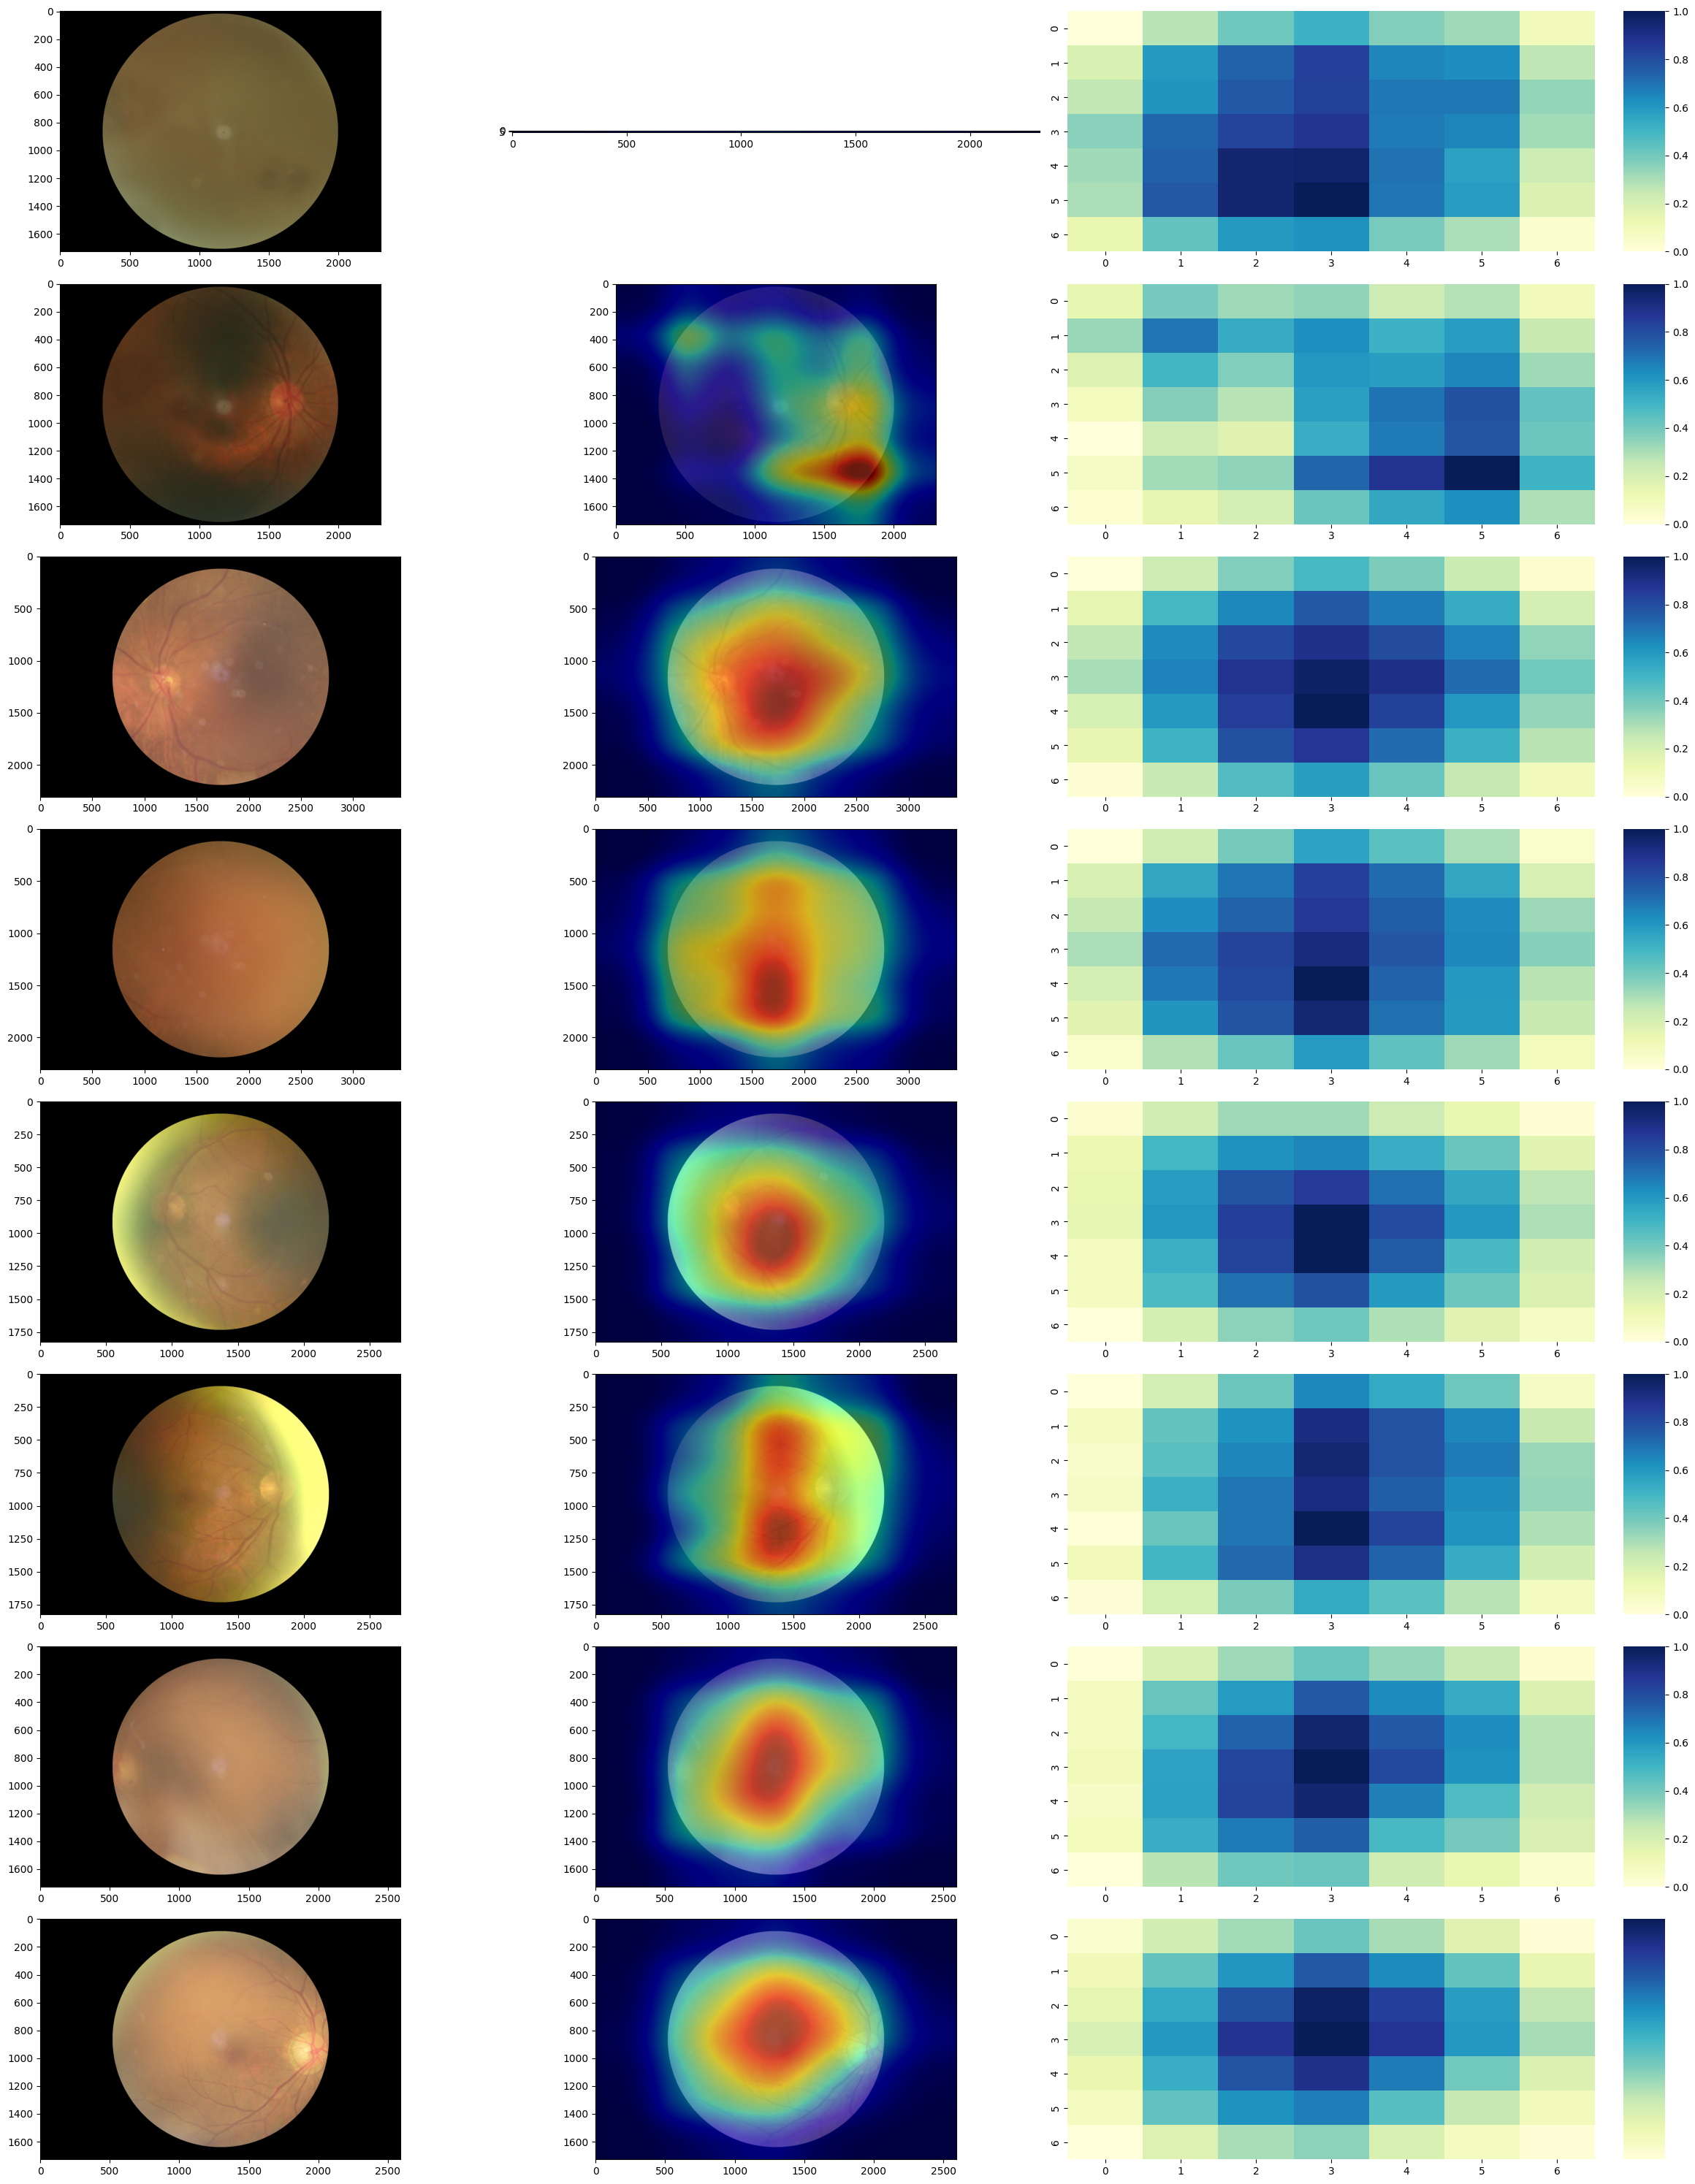

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the raw CAM
model1 = resnet18(pretrained= True).eval()
# Get your input
count=0
plt.figure(figsize=(12,6))
plt.rcParams['figure.figsize'] = [24, 30]
fig, axs = plt.subplots(8,4,
            gridspec_kw={'width_ratios':[1,1,1,0.08]})
axs[0,0].get_shared_y_axes().join(axs[0,1],axs[0,2])
g=[]
for i in range(8):
  g.append("")
for i in range(1000):
  try:
    img = read_image(f"/content/data/train/C/{i}_left.jpg")
    # Preprocess it for your chosen model
    input_tensor = resize(img, (224, 224)) / 255.

    # print(input_tensor.unsqueeze(0).shape)

    with SmoothGradCAMpp(model1,target_layer='layer4') as cam_extractor:
      # Preprocess your data and feed it to the model
      out = model1(input_tensor.unsqueeze(0))
      # Retrieve the CAM by passing the class index and the model output
      activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    m=activation_map[0].squeeze(0).numpy()
    g[count] = sns.heatmap(m,cmap="YlGnBu", cbar_ax=axs[count,3],ax=axs[count,2])
    g[count].set_ylabel('')
    g[count].set_xlabel('')


    input_tensor = resize(img, (224, 224)) / 255.

    print(input_tensor.unsqueeze(0).shape)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    axs[count,0].imshow(to_pil_image(img))
    axs[count,1].imshow(result)


    count+=1
    if(count == 8):
      break
    img = read_image(f"/content/data/train/C/{i}_right.jpg")
    # Preprocess it for your chosen model
    input_tensor = resize(img, (224, 224)) / 255.

    # print(input_tensor.unsqueeze(0).shape)

    with SmoothGradCAMpp(model1,target_layer='layer4') as cam_extractor:
      # Preprocess your data and feed it to the model
      out = model1(input_tensor.unsqueeze(0))
      # Retrieve the CAM by passing the class index and the model output
      activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    m=activation_map[0].squeeze(0).numpy()
    g[count] = sns.heatmap(m,cmap="YlGnBu", cbar_ax=axs[count,3],ax=axs[count,2])
    g[count].set_ylabel('')
    g[count].set_xlabel('')


    input_tensor = resize(img, (224, 224)) / 255.

    print(input_tensor.unsqueeze(0).shape)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    axs[count,0].imshow(to_pil_image(img))
    axs[count,1].imshow(result)


    count+=1
    if(count == 8):
      break
  except:
    pass

# plt.figure(figsize=(10,6))
plt.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

2/2 [==============================] - 1s 210ms/step
